# Term structure factors and SABR

This notebook demonstrates a front-office style workflow for **rates term-structure + volatility modeling**:

- **Term-structure representation (Diebold–Li / Nelson–Siegel):** build the measurement loading matrix $H(\lambda)$ mapping latent factors (level, slope, curvature) to observed yields across maturities.
- **State-space inference (Kalman filter):** estimate and filter the latent factor time series from noisy yield observations using standard linear-Gaussian KF prediction/update steps.
- **Continuous-time dynamics (OU / Hull–White style factors):** model factor evolution with mean reversion and stochastic shocks in continuous time.
- **Exact discretization (Van Loan):** discretize the OU dynamics into a VAR(1) form $(F, C, Q)$ via a single block-matrix exponential, enabling stable daily-step simulation and scenario generation.
- **Volatility modeling (SABR / HKLW):** compute implied volatilities using the Hagan–Kumar–Lesniewski–Woodward approximation and calibrate $(\alpha, \rho, \nu)$ to smile quotes (with $\beta$ fixed for the demo).
- **Implementation signal (C++ + Python):** numerically sensitive components run in `C++` for performance/clarity; `Python` is used for data handling, visualization, and experimentation.

**Outputs produced in this demo**
- Filtered DL factor paths (level/slope/curvature) and example plots
- OU-discretized transition/covariance $(F, C, Q)$ suitable for Monte Carlo scenarios
- SABR parameter fit summary and fit-vs-market diagnostics


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
import rates_kf_sabr as rks

## 1) Simulated yields and Diebold–Li measurement matrix
In production you'd ingest market data (par swap rates / govvies) and map to zero yields.


In [2]:
taus = np.array([0.25, 0.5, 1, 2, 5, 10, 30], dtype=float)
lam = 2.0
H = rks.diebold_li_loadings(taus.tolist(), lam)

# Create a toy latent factor path and noisy yields
Tn = 250
x_true = np.zeros((Tn, 3))
x_true[0] = np.array([0.03, -0.02, 0.01])
for t in range(1, Tn):
    x_true[t] = x_true[t-1] + np.array([0.00002, 0.00001, -0.00001]) + 0.0005*np.random.randn(3)
y = (H @ x_true.T).T + 0.0005*np.random.randn(Tn, len(taus))
y[:3]

array([[0.01228985, 0.01353572, 0.01499052, 0.020578  , 0.02591811,
        0.02733321, 0.02862844],
       [0.01049803, 0.01272892, 0.01501965, 0.01870346, 0.02488586,
        0.02813822, 0.02821098],
       [0.01042096, 0.01168045, 0.01371239, 0.01751001, 0.02384994,
        0.0258667 , 0.02763172]])

In [3]:
#same as above array but tabulated for better visual inspection
df_y3 = pd.DataFrame(y[:3], columns=[f"{t:g}Y" for t in taus])
df_y3.index = [f"t={i}" for i in range(3)]
df_y3.style.format("{:.6f}")

,0.25Y,0.5Y,1Y,2Y,5Y,10Y,30Y
t=0,0.012290,0.013536,0.014991,0.020578,0.025918,0.027333,0.028628
t=1,0.010498,0.012729,0.015020,0.018703,0.024886,0.028138,0.028211
t=2,0.010421,0.011680,0.013712,0.017510,0.023850,0.025867,0.027632


## 2) OU discretization via Van Loan and Kalman filter
The note derives the VAR(1) representation where `F = exp(-kappa dt)` and `Q` is extracted from a single block matrix exponential.


In [4]:
dt = 1/252
kappa = np.eye(3) * 0.3
theta = np.array([0.03, -0.02, 0.01])
Sigma = np.eye(3) * 0.02

F, C, Q = rks.discretize_ou_van_loan(kappa, theta, Sigma, dt)
R = np.eye(len(taus)) * (0.0005**2)

x0 = np.array([0.02, -0.01, 0.005])
P0 = np.eye(3) * 1e-3

kf = rks.KalmanFilter(H, F, C, Q, R, x0, P0)
x_filt = np.zeros((Tn, 3))
for t in range(Tn):
    x_filt[t] = kf.step(y[t])

pd.DataFrame(x_filt, columns=['level','slope','curvature']).head()

,level,slope,curvature
0,0.029083,-0.019151,0.012090
1,0.029135,-0.020365,0.011463
2,0.028277,-0.020113,0.009425
3,0.029368,-0.021171,0.009340
4,0.029036,-0.021644,0.010905


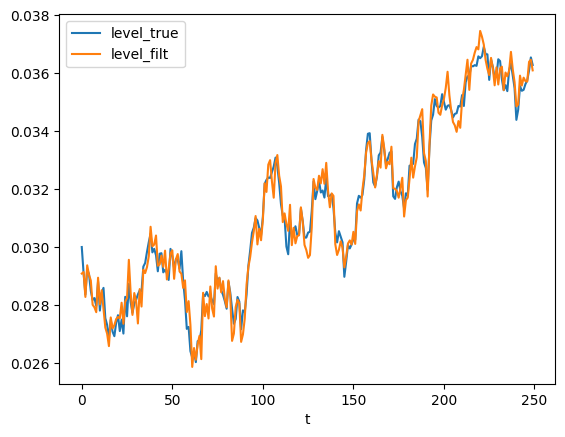

In [5]:
df = pd.DataFrame({
    't': np.arange(Tn),
    'level_true': x_true[:,0], 'level_filt': x_filt[:,0],
    'slope_true': x_true[:,1], 'slope_filt': x_filt[:,1],
    'curv_true': x_true[:,2], 'curv_filt': x_filt[:,2],
})
ax = df.plot(x='t', y=['level_true','level_filt'])
plt.show()

## 3) SABR implied vols and calibration (beta fixed)
Demonstration of HKLW formula and a lightweight calibration routine.


In [6]:
Fwd = 0.03
Tmat = 2.0
beta = 0.5

Ks = np.array([0.01, 0.02, 0.03, 0.04, 0.05])
true = dict(alpha=0.02, rho=-0.25, nu=0.6)
vols = np.array([rks.sabr_iv_hagan(Fwd, k, Tmat, true['alpha'], beta, true['rho'], true['nu']) for k in Ks])
vols = vols * (1 + 0.02*np.random.randn(len(vols)))  # add tiny noise
alpha, rho, nu, iters, rmse = rks.sabr_calibrate_beta_fixed(Fwd, Tmat, beta, Ks.tolist(), vols.tolist(), 0.015, -0.10, 0.4)
alpha, rho, nu, iters, rmse

(0.0027928742246053364,
 -0.20558890499999918,
 0.5961354271357497,
 3000,
 149745206.96024042)

In [7]:
fit = np.array([rks.sabr_iv_hagan(Fwd, k, Tmat, alpha, beta, rho, nu) for k in Ks])
pd.DataFrame({'K':Ks, 'market':vols, 'fit':fit, 'err':fit-vols})

,K,market,fit,err
0,0.01,3.600559e-01,1.774350e-01,-1.826209e-01
1,0.02,1.987703e-01,8.164431e-02,-1.171260e-01
2,0.03,1.229747e-01,1.701129e-02,-1.059634e-01
3,0.04,-1.813825e+11,-1.810892e+11,2.933013e+08
4,0.05,-3.219957e+11,-3.221573e+11,-1.615318e+08


In [8]:
Path("outputs").mkdir(exist_ok=True)
np.savez( "outputs/demo_data.npz",
    taus=taus,y=y,lam=lam,Fwd=Fwd,Tmat=Tmat,beta=beta,K=Ks,vols=vols)
print("Wrote outputs/demo_data.npz")

Wrote outputs/demo_data.npz
